# Geographical Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from libpysal.weights import KNN
import pysal.model.spreg as spreg

import geopandas as gpd
from pysal.lib import weights
from pysal.explore import esda
from shapely.geometry import Point

from kmodes.kprototypes import KPrototypes



/opt/anaconda3/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/opt/anaconda3/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/opt/anaconda3/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:199: N

In [3]:
ori = pd.read_csv('Original.csv')

In [4]:
import plotly.express as px


# Create a scatter mapbox plot
fig = px.scatter_mapbox(ori, lat='Latitude', lon='Longitude', zoom=5, color='Churn Label', #Churn Label can be changes to any other features to visualize
                      color_discrete_map={'No': 'Yellow', 'Yes': 'Red'})

# Update the map layout
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(height=700, width=800)

# Show the plot
fig.show()


We see that individuals are not bound to a single location but rather they are distributed. It would however better to confirm whether there is any hiddne patterns with location and different features. I will go over some of statistical techniques for analyzing and identify the locational behavior

In [30]:
#Import Encoded Data
df = pd.read_csv('geo.csv')
df = df.drop(columns = [df.columns[0]])

In [31]:
df.head()

,Total Long Distance Charges,Total Revenue,Contract_Two Year,Payment Method_Credit Card,Internet Service,Contract_Month-to-Month,Internet Type_None,Total Charges,Internet Type_Fiber Optic,Contract_One Year,Tenure in Months,Monthly Charge,Number of Dependents,Offer_Offer E,Number of Referrals,Churn Label,Latitude,Longitude
0,0.00,59.65,0,0,1,1,0,39.65,0,0,1,39.65,0,0,0,1,34.02381,-118.156582
1,3063.60,8080.25,1,1,1,0,0,5016.65,0,0,72,72.10,0,0,5,0,34.02381,-118.156582
2,7.11,82.66,0,0,1,1,0,75.55,1,0,1,75.55,0,0,0,0,34.02381,-118.156582
3,0.00,3708.40,1,1,1,0,0,3708.40,0,0,66,56.75,3,0,4,0,34.02381,-118.156582
4,255.43,888.88,0,1,1,0,0,633.45,1,1,7,94.05,0,1,0,0,34.02381,-118.156582


## Spatial Lag Regression Model
- A spatial lag regression model is a statistical method used when we think data points in close physical (or spatial) proximity to each other might influence each other.
- In the case of churn data, we're assuming that the behavior of a customer might be influenced by the behavior of other customers that are spatially close

In [32]:
# Create a weights matrix based on the longitude and latitude
# Using KNN (k-nearest neighbors) with 10 neighbors
coords = df[['Longitude', 'Latitude']].values
w = KNN(coords, k=10)

# Make sure the weights matrix is symmetric
w.transform = 'R'

# Define the dependent variable (churn label)
y = df['Churn Label'].values.reshape((-1, 1))

# Define independent variables (Some of the correlated Features are removed)
X_cols =  ['Total Long Distance Charges',
            'Total Revenue',
            'Payment Method_Credit Card',
            'Internet Service',
            'Contract_Month-to-Month',
            'Internet Type_None',
            'Total Charges',
            'Internet Type_Fiber Optic',
            'Tenure in Months',
            'Monthly Charge',
            'Number of Dependents',
            'Offer_Offer E',
            'Number of Referrals']

X = df[X_cols].values

# Run the model
model = spreg.ML_Lag(y, X, w=w, name_x=X_cols, name_y='Churn Label')

# Print the summary
print(model.summary)


/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 13 disconnected components.

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:892: RuntimeWarning:

Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.



REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : Churn Label                Number of Observations:        7043
Mean dependent var  :      0.2654                Number of Variables   :          15
S.D. dependent var  :      0.4416                Degrees of Freedom    :        7028
Pseudo R-squared    :      0.1332
Spatial Pseudo R-squared:  0.1316
Sigma-square ML     :       0.209                Log likelihood        :   -4476.922
S.E of regression   :       0.457                Akaike info criterion :    8983.843
                                                 Schwarz criterion     :    9086.740

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

- Number of Referrals: The more referrals a customer made, the less likely they are to churn. This result is statistically significant.
- Offer_Offer E: Customers who received offer E are more likely to churn. This result is statistically significant.
- Number of Dependents: Customers with more dependents are less likely to churn. This result is statistically significant
- Monthly Charge: An increase in the monthly charge leads to a higher likelihood of churn, and this result is statistically significant.
- Tenure in Months: The longer a customer stays, the less likely they are to churn. This result is statistically significant.
- Contract_Month-to-Month: Customers with a month-to-month contract are significantly more likely to churn, with the result being statistically significant.

W_Churn Label: implying that there's indeed spatial autocorrelation in your data. That is, the churn status of neighboring data points influences the churn status of each data point.

Spatial Pseudo R-squared:  0.1316
- This indicates that the model is explaining about 13% of the variability in the churn label.

Conclusion:
-  The model did find some locational influence on the churn rate, however because we have only seen 13% of the variability, we cannot conclude that location is the most prominent in churn


## Moran's I Statistics
- It is a measure of spatial autocorrelation, which means it helps to evaluate whether the pattern expressed is clustered, dispersed, or random.
-  Moran's I is a number that helps us understand if those who churn are located close to each other on the map or if their distribution appears random.

In [33]:
# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

# Compute spatial weights
w = weights.KNN.from_dataframe(geo_df, k=8)

# Ensure the weights are symmetric
w.transform = 'R'

# Compute Moran's I
mi = esda.Moran(geo_df['Churn Label'], w)

print('Moran\'s I: ', mi.I)
print('Expected I: ', mi.EI)
print('p-value: ', mi.p_sim)


/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:39: FutureWarning:

The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.

/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 101 disconnected components.



Moran's I:  0.05742457813204809
Expected I:  -0.00014200511218403862
p-value:  0.001


Moran's I is positive and significantly different from the expected I (given the p-value of 0.001), suggesting that there is a clustering of similar churn values in your data.
- customers who churn (or don't churn) are not randomly distributed but instead tend to be located near each other.

Conclusion:
- Moran's I value is relatively small, indicating that while the spatial autocorrelation is statistically significant, the strength of this clustering is not particularly strong.

## K-Prototypes Clustering
- Performing clustering will make sure whether closely located customers share similar characteristics

In [35]:
# assuming df is your DataFrame and you've already done any necessary preprocessing
kproto = KPrototypes(n_clusters=3, init='Huang')  # change n_clusters as needed

# note: you need to specify which columns are categorical
categorical_columns = ['Contract_Two Year', 'Payment Method_Credit Card', 'Internet Service', 
                       'Contract_Month-to-Month', 'Internet Type_None', 'Internet Type_Fiber Optic', 
                       'Contract_One Year', 'Offer_Offer E', 'Tenure in Months', 'Monthly Charge','Number of Referrals', 'Total Charges' , 'Churn Label']

categorical_column_indices = [df.columns.get_loc(col) for col in categorical_columns]

clusters = kproto.fit_predict(df, categorical=categorical_column_indices)

# add the cluster labels to your dataframe
df['Cluster'] = clusters

# you can also view the mean churn rate per cluster
print('Mean Churn Rate by Cluster:\n', df.groupby('Cluster')['Churn Label'].mean())


Mean Churn Rate by Cluster:
 Cluster
0    0.180270
1    0.138187
2    0.357568
Name: Churn Label, dtype: float64


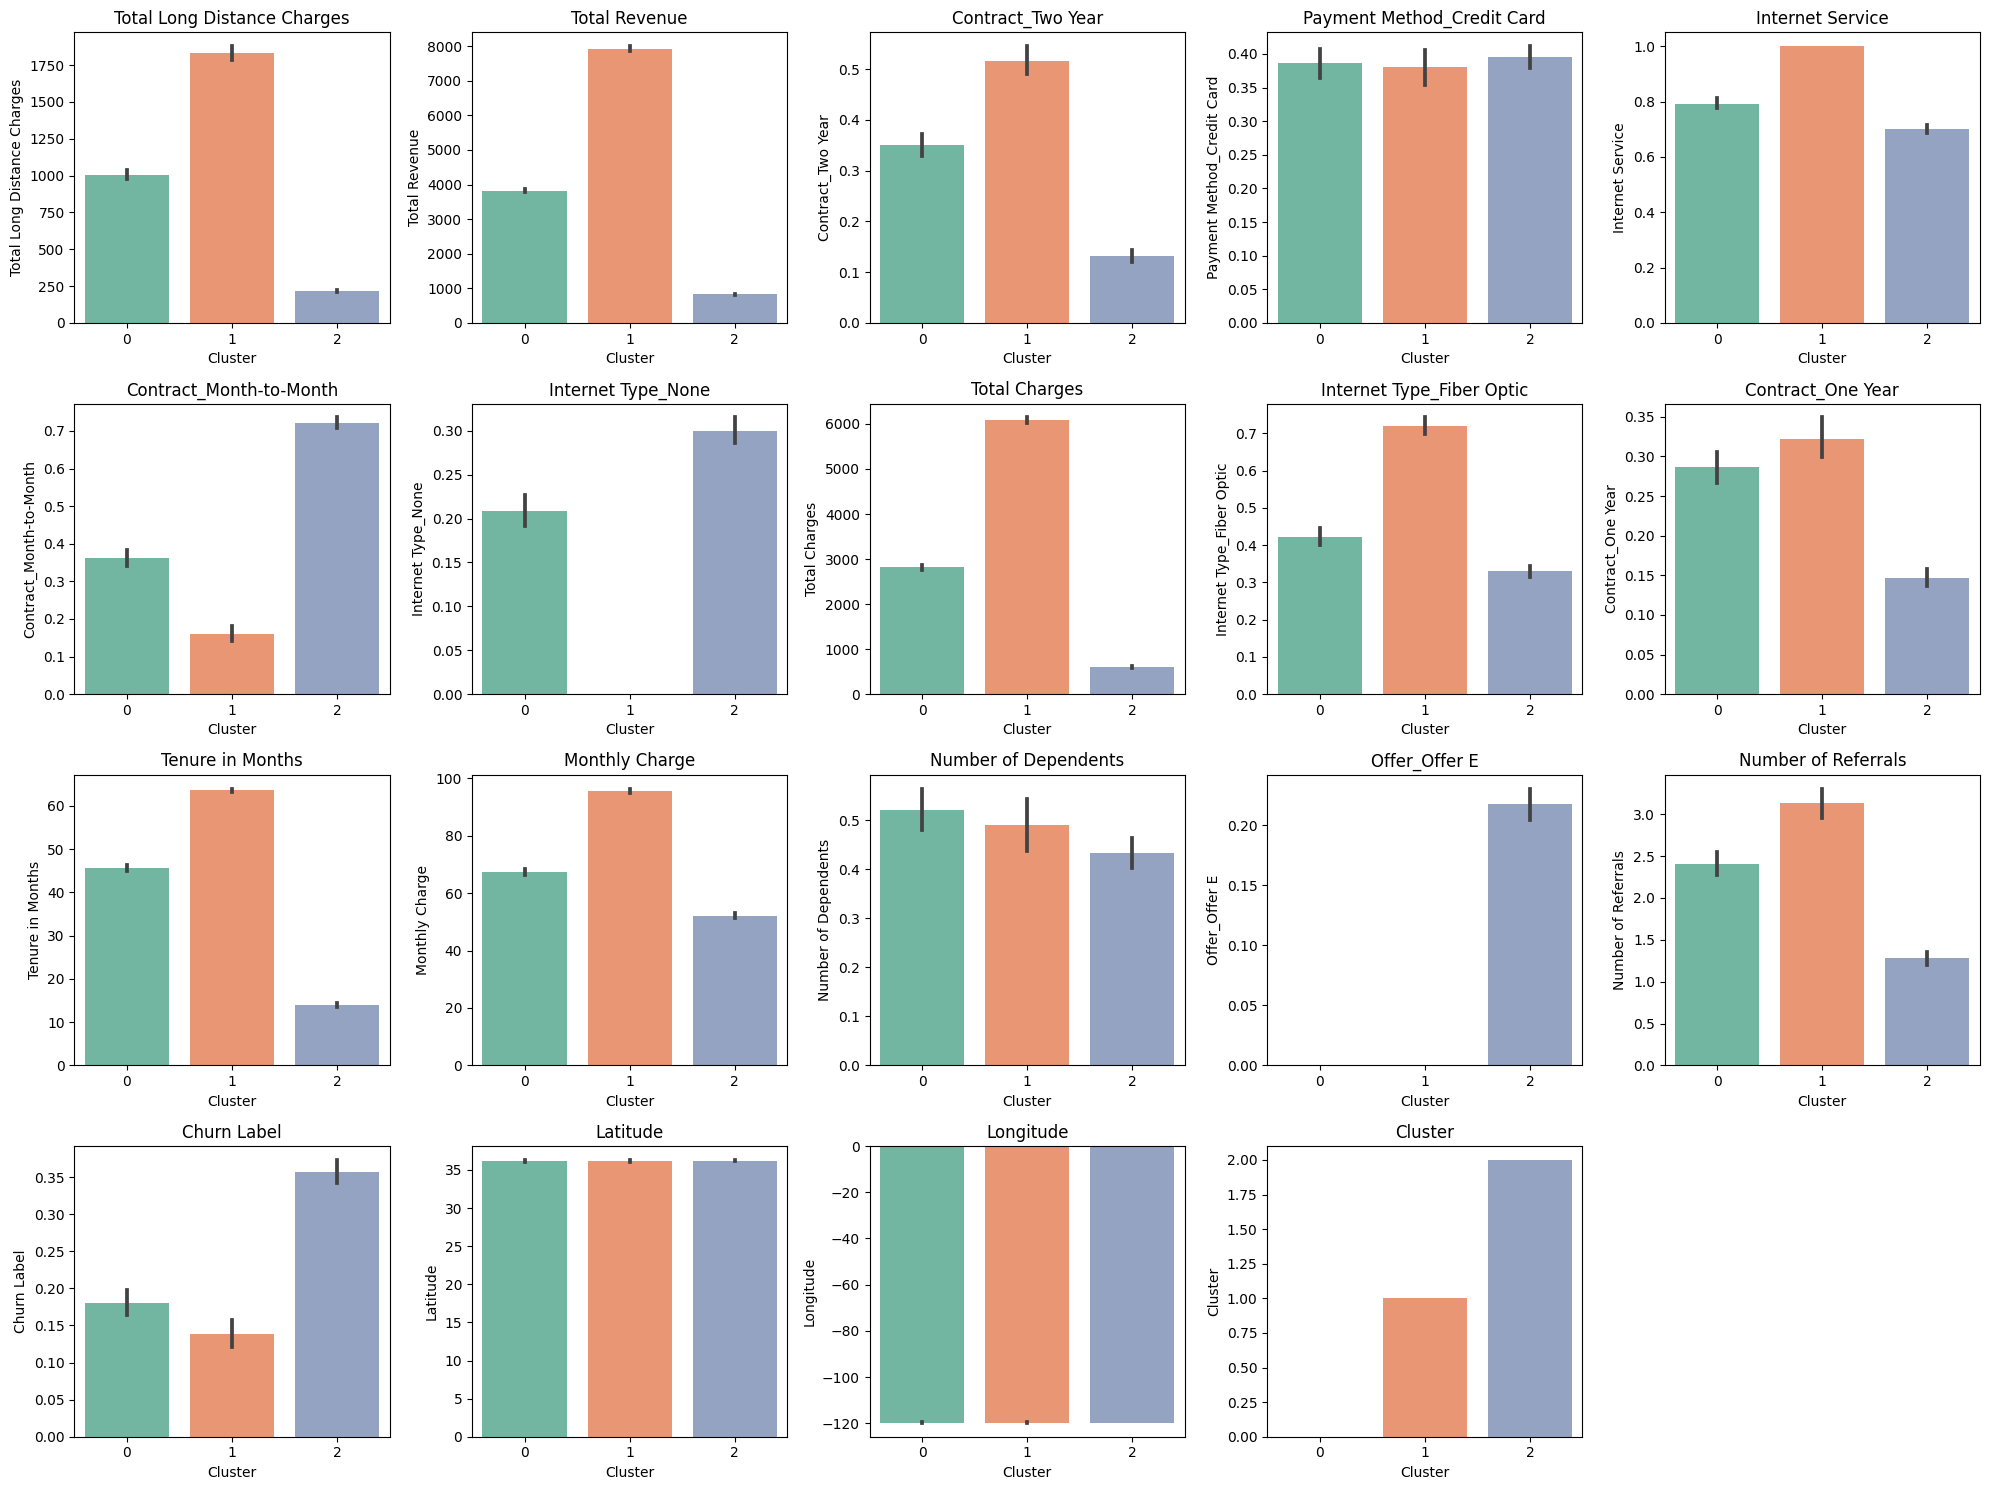

In [38]:
# Plotting
plt.figure(figsize=(20,15))
for i, col in enumerate(df.columns):
    plt.subplot(4, 5, i+1)
    sns.barplot(x='Cluster', y=col, data=df, palette='Set2')
    plt.title(col)
    
plt.tight_layout()
plt.show()


In [39]:
df['Cluster'].value_counts()

2    3700
0    1997
1    1346
Name: Cluster, dtype: int64

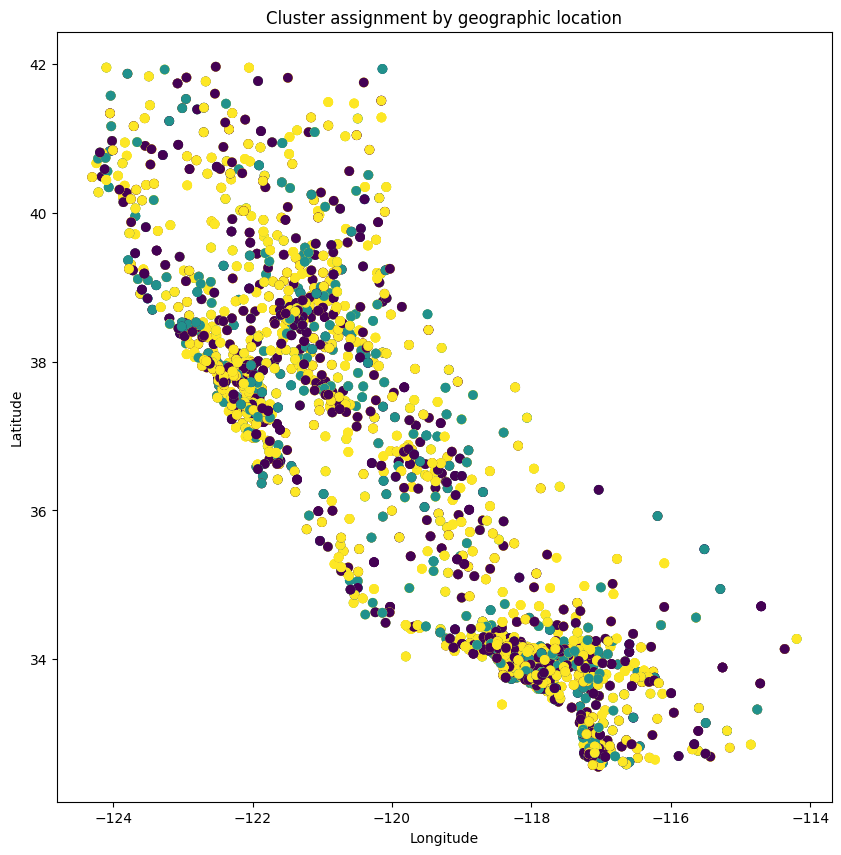

In [41]:
plt.figure(figsize=(10,10))

# Create a scatterplot of longitude vs. latitude, colored by cluster
# Assuming df['Longitude'] and df['Latitude'] are your longitudes and latitudes
# and df['cluster'] is your cluster assignments
plt.scatter(df['Longitude'], df['Latitude'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cluster assignment by geographic location')
plt.show()


From the K-Prototype (Alternative of KMeans) clusters, the location does not show high correlation with cluster information. (Closely located samples does not share similar characteristics)

Findings:
- We see that the cluster 2 shows the highest churn rate
- Their distinct characteristics involve, Mostly in Month to Month contract as well as having an Offer E.

Conclusion:
- From a business perspective, the two features (Month to Month Contract as well as Offer E) having customers have the highest chance of churning and therefore need additional attention to these customers. However, Cluster 2 is also the most Prominent (In terms of their number) and therefore may require additional analysis to narrow donw the sample numbers

## Geographical Analysis Summary

- Geogrpahical correlation exists but it is very weak and therefore depending heavily on the location may not be approrpriate

- Clustering analysis showed, certain customers are more likely to churn (Offer and Contract Type) 

- Clustering confirmed that there is no clear pattern of location + customer's characteristics